In [36]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [37]:
raw = pd.read_excel('V3 Gies Sales Account 360 Data Set 1.xlsx')
print(raw.head())
raw = raw.dropna(subset=['PO Count'])
columns_to_check = ['Weight', 'Cases', 'Lines', 'Pallets', 'Cases/Line']
raw = raw[(raw[columns_to_check] >= 0).all(axis=1)]
clean = raw[raw['Item Spread'] <= 1]
print(clean.describe())

   Period     Load  Company ID Customer #/Ship To                    Company  \
0       1  9643113    13831201          138312-01  GROCERY SUPPLY/SULPHUR SP   
1       1  9642714    12654200          126542-00               M R WILLIAMS   
2       1  9642777    12654200          126542-00               M R WILLIAMS   
3       1  9642693    23820501          238205-01                     K-VA-T   
4       1  9642532      346000          003460-00      PERF FS/BOWLING GREEN   

  State        Tier   Weight   Cases  Lines  Pallets  Cases/Line  PO Count  \
0    TX      Tier I  28709.0  3810.0  270.0     15.0   14.111111      61.0   
1    NC      Tier I   9542.0  1492.0  105.0      6.0   14.209524      13.0   
2    NC      Tier I  30658.0  5007.0  255.0     20.0   19.635294       1.0   
3    VA      Tier I  24511.0  2673.0   77.0     25.0   34.714286       1.0   
4    KY  Corporates  30827.0  1510.0  128.0     11.0   11.796875       8.0   

   Item Spread  Dock Time (Hours)         Sales Re

     Period     Load  Company ID Customer #/Ship To                  Company  \
146       1  9643456    14603400          146034-00       DOUGLAS CO./CONWAY   
241       1  9643316     1328301          013283-01         PERF FS/VALDOSTA   
254       1  9643580      372500          003725-00             BRIGGS, INC.   
259       1  9645702    24231100          242311-00  SFS DIST - SKOUFIS FOOD   
260       1  9645705    14751400          147514-00           CRISTINA FOODS   

    State        Tier   Weight   Cases  Lines  Pallets  Cases/Line  PO Count  \
146    AR     Tier II  16693.0  3312.0  182.0     20.0   18.197802      38.0   
241    GA  Corporates  36773.0  2804.0  173.0     15.0   16.208092       8.0   
254    MS     Tier II  15979.0  1296.0  122.0      9.0   10.622951       5.0   
259    IL    Tier III   7938.0   466.0   25.0      4.0   18.640000       5.0   
260    IL    Tier III   5849.0   335.0   11.0      2.0   30.454545       1.0   

     Item Spread  Dock Time (Hours)   

C:\Users\81623\AppData\Local\Temp\ipykernel_7520\549309591.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean.loc[:, 'Log Cases/Line'] = np.log1p(clean['Cases/Line'])
C:\Users\81623\AppData\Local\Temp\ipykernel_7520\549309591.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean.loc[:, 'Log PO Count'] = np.log1p(clean['PO Count'])
C:\Users\81623\AppData\Local\Temp\ipykernel_7520\549309591.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

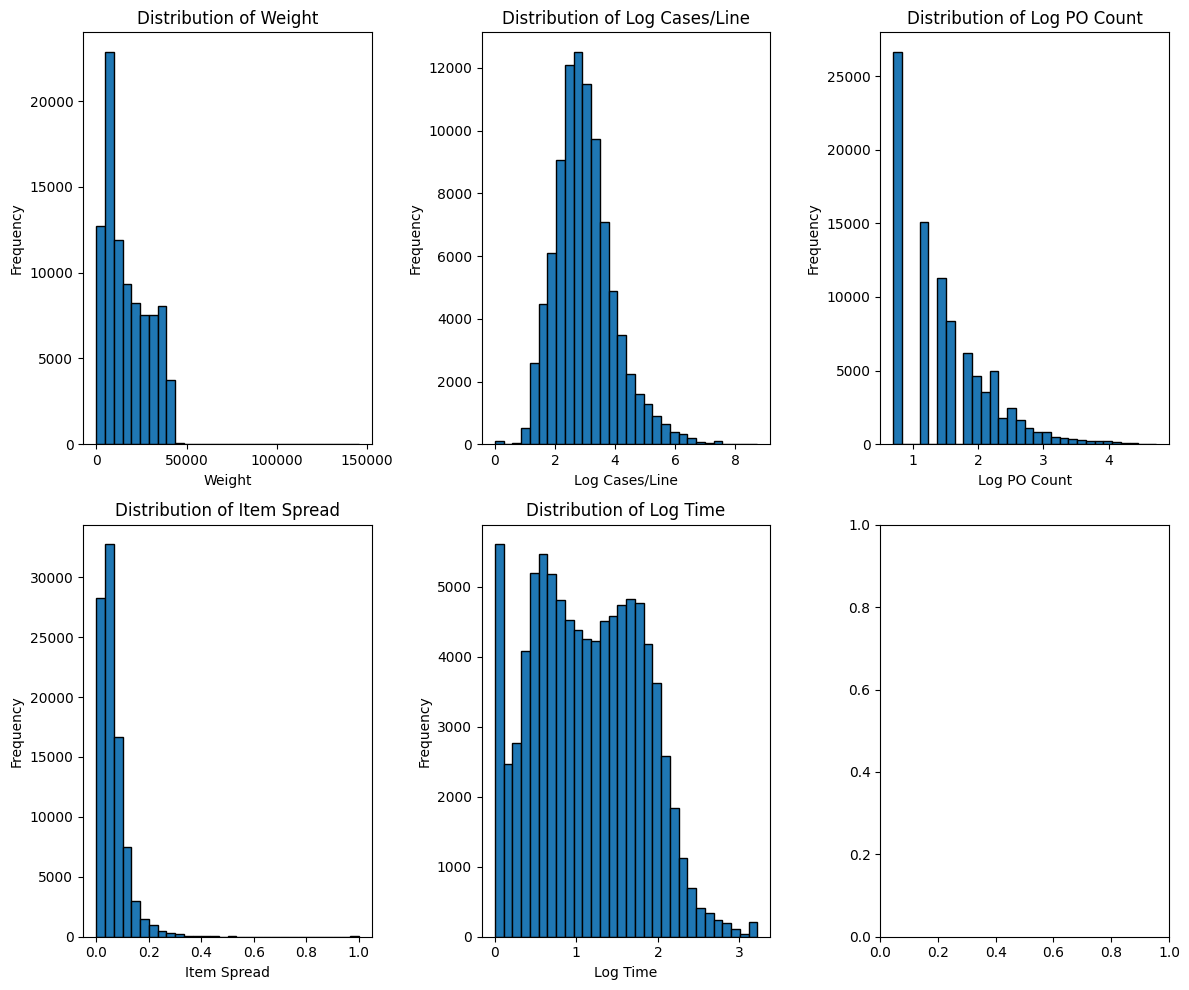

In [38]:
# Convert into log scale using .loc
clean.loc[:, 'Log Cases/Line'] = np.log1p(clean['Cases/Line'])
clean.loc[:, 'Log PO Count'] = np.log1p(clean['PO Count'])
clean.loc[:, 'Log Time'] = np.log1p(clean['Dock Time (Hours)'])

print(clean.head())

# Plot distributions
fig, axes = plt.subplots(2, 3, figsize=(12, 10))
features = ['Weight', 'Log Cases/Line', 'Log PO Count', 'Item Spread', 'Log Time']

for ax, feat in zip(axes.flatten(), features):
    ax.hist(clean[feat], bins=30, edgecolor='black')
    ax.set_title(f'Distribution of {feat}')
    ax.set_xlabel(feat)
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

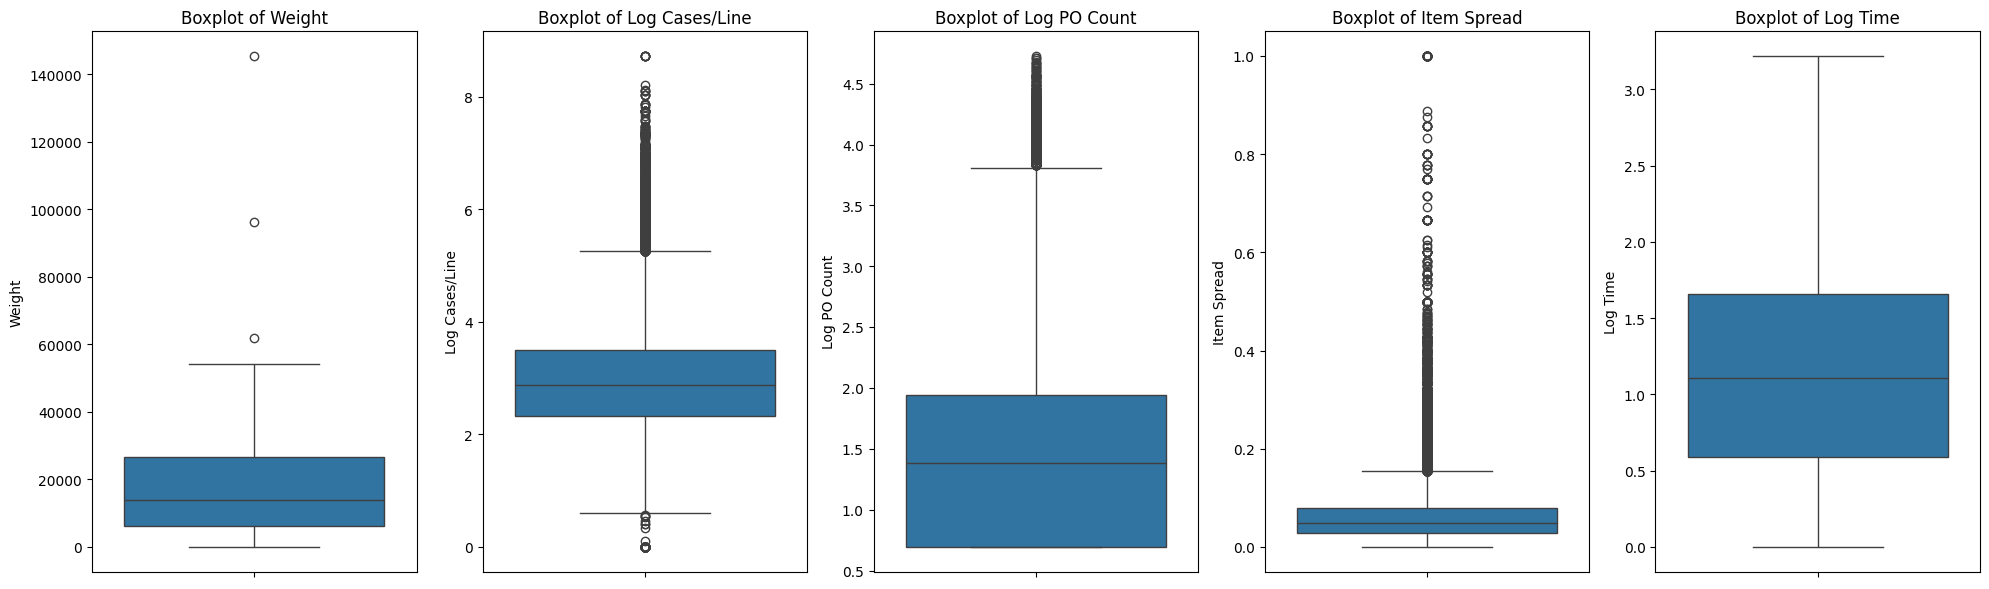

In [39]:
# Boxplot to check for outliers
fig, axes = plt.subplots(1, len(features), figsize=(20, 6), sharey=False)

for ax, feature in zip(axes, features):
    sns.boxplot(data=clean, y=feature, ax=ax)
    ax.set_title(f'Boxplot of {feature}')
    ax.set_ylabel(feature)

plt.tight_layout()
plt.show()

In [40]:
# Use the IQR method to cap outliers
for feature in features:
    Q1 = clean[feature].quantile(0.25)  # First quartile (25th percentile)
    Q3 = clean[feature].quantile(0.75)  # Third quartile (75th percentile)
    IQR = Q3 - Q1  # Interquartile range
    lower_bound = Q1 - 1.5 * IQR  # Lower bound
    upper_bound = Q3 + 1.5 * IQR  # Upper bound

    # Replace outliers with the lower and upper bounds using .loc
    clean.loc[:, feature] = clean[feature].clip(lower=lower_bound, upper=upper_bound)

# Check the data after capping
print(clean[features].describe())

             Weight  Log Cases/Line  Log PO Count   Item Spread      Log Time
count  91999.000000    91999.000000  91999.000000  91999.000000  91999.000000
mean   16877.586746        2.964796      1.465934      0.058611      1.132259
std    11924.200518        0.926827      0.720971      0.039363      0.661248
min        0.000000        0.575761      0.693147      0.000000      0.000000
25%     6223.000000        2.329853      0.693147      0.029070      0.592336
50%    13827.000000        2.873475      1.386294      0.049080      1.110395
75%    26767.000000        3.499247      1.945910      0.079208      1.656482
max    57583.000000        5.253339      3.825055      0.154415      3.218865


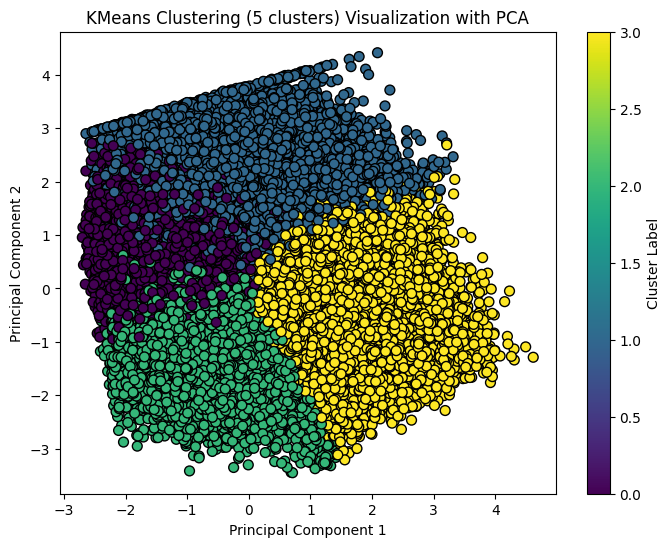

In [41]:
scaler = StandardScaler()
X_features = clean[features]

# 1. Standardize the features
scaler_new = scaler.__class__()  # reinitialize a new scaler using the same StandardScaler class
X_scaled_new = scaler_new.fit_transform(X_features)

# 2. KMeans clustering with 4 clusters
kmeans_4 = KMeans(n_clusters=4, random_state=42)
labels_4 = kmeans_4.fit_predict(X_scaled_new)

# 3. PCA to reduce to 2 dimensions for visualization
pca_2d_new = PCA(n_components=2)
X_pca_2d = pca_2d_new.fit_transform(X_scaled_new)

# 4. Plot the PCA results, colored by cluster labels
plt.figure(figsize=(8, 6))
plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=labels_4, cmap='viridis', edgecolor='k', s=50)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMeans Clustering (5 clusters) Visualization with PCA')
plt.colorbar(label='Cluster Label')
plt.show()

In [42]:
# Apply the color coding to the loading matrix using Styler.map
styled_loading_matrix = loading_matrix.style.map(color_coding)

# Display the styled loading matrix
styled_loading_matrix


,PC1,PC2
Weight,0.606174,0.217839
Log Cases/Line,-0.126104,0.657969
Log PO Count,0.517959,-0.309684
Item Spread,0.014385,0.627422
Log Time,0.590053,0.173378


In [43]:
# Assign the kMeans cluster labels from labels_4 to the 'clean' DataFrame
clean.loc[:, 'Cluster'] = labels_4

# Print the first few rows to inspect the new "Cluster" column
print(clean.head())

# Count the number of samples in each cluster
print(clean['Cluster'].value_counts())

     Period     Load  Company ID Customer #/Ship To                  Company  \
146       1  9643456    14603400          146034-00       DOUGLAS CO./CONWAY   
241       1  9643316     1328301          013283-01         PERF FS/VALDOSTA   
254       1  9643580      372500          003725-00             BRIGGS, INC.   
259       1  9645702    24231100          242311-00  SFS DIST - SKOUFIS FOOD   
260       1  9645705    14751400          147514-00           CRISTINA FOODS   

    State        Tier   Weight   Cases  Lines  Pallets  Cases/Line  PO Count  \
146    AR     Tier II  16693.0  3312.0  182.0     20.0   18.197802      38.0   
241    GA  Corporates  36773.0  2804.0  173.0     15.0   16.208092       8.0   
254    MS     Tier II  15979.0  1296.0  122.0      9.0   10.622951       5.0   
259    IL    Tier III   7938.0   466.0   25.0      4.0   18.640000       5.0   
260    IL    Tier III   5849.0   335.0   11.0      2.0   30.454545       1.0   

     Item Spread  Dock Time (Hours)   

C:\Users\81623\AppData\Local\Temp\ipykernel_7520\1425526819.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean.loc[:, 'Cluster'] = labels_4


In [44]:
cluster_stats = clean.groupby('Cluster')[['Weight', 'Log Cases/Line', 'Log PO Count', 'Item Spread', 'Log Time']].describe()
print(cluster_stats)

          Weight                                                       \
           count          mean           std   min       25%      50%   
Cluster                                                                 
0        17584.0   8945.407700   6654.329663  41.0   4962.00   6737.0   
1        15107.0  21120.530416  11559.962361  25.0  10742.00  21455.0   
2        29088.0   8450.823604   5913.129025   0.0   4829.00   6977.0   
3        30220.0  27483.111979   8955.635659   0.0  20677.75  28281.0   

                           Log Cases/Line            ... Item Spread  \
              75%      max          count      mean  ...         75%   
Cluster                                              ...               
0        11575.50  43067.0        17584.0  3.990594  ...    0.069767   
1        30978.50  44389.0        15107.0  3.698544  ...    0.154415   
2        11172.50  42085.0        29088.0  2.171051  ...    0.053435   
3        35106.75  57583.0        30220.0  2.765130  ...

🔵 Cluster 0: Small-to-Medium Volume Clients with Fast Loading and Large Single Orders
Transport volume is low to medium (Weight ≈ 8,945).

Large shipment per order: Log Cases/Line ≈ 4, indicating high load per shipment.

Moderate order frequency: PO Count is not particularly high.

Minimal vehicle allocation: Item Spread is very low, usually one truck per order.

Fast loading: Dock Time ≈ 0.73, indicating high loading efficiency.

✅ Client Profile Summary:
Small-to-medium clients with efficient loading and high-volume single shipments. Typically traditional industries shipping bulk goods to single destinations with simple logistics needs.

🎯 Operational Suggestion:
Offer standardized bulk transportation packages to encourage repeat orders.

🟢 Cluster 1: Medium-to-High Volume Clients with Stable Orders and Moderate Vehicle Distribution
Higher transport volume: Weight ≈ 21,120.

Moderate load per order: Log Cases/Line ≈ 3.7.

Moderate to high order frequency: Clients are relatively active.

Moderate vehicle allocation: Item Spread ≈ 0.12, indicating some dispatch complexity.

Average-to-slow loading: Dock Time ≈ 1.29.

✅ Client Profile Summary:
Reliable and active mid-to-large clients with predictable logistics needs and moderate vehicle dispatch demands.

🎯 Operational Suggestion:
Sign mid-to-long-term logistics agreements and offer scheduled loading services to ensure turnaround efficiency.

🟡 Cluster 2: Low-Volume, Infrequent Clients with Small Orders and Fast Turnaround
Lowest transport volume: Weight ≈ 8,450.

Small load per shipment: Log Cases/Line ≈ 2.1.

Very low order frequency: PO Count is minimal, indicating occasional use.

Minimal vehicle usage: Item Spread ≈ 0.05.

Quick loading: Dock Time ≈ 0.69.

✅ Client Profile Summary:
Ad-hoc or sporadic clients with small-scale shipments and simple operational requirements. High likelihood of one-off usage.

🎯 Operational Suggestion:
Use flexible, on-demand transport offerings; avoid overcommitting long-term resources. Best suited for backfill or low-load route optimization.

🔴 Cluster 3: Strategic Clients with Extremely High Volume, High Order Frequency, and Complex Loading
Highest transport volume: Weight ≈ 27,483.

Moderate per-order load: Log Cases/Line ≈ 2.76.

Highest order frequency: PO Count is the highest among all clusters.

Significant vehicle allocation: Item Spread ≈ 0.06.

Slowest loading time: Dock Time ≈ 1.70, due to large volume and product complexity.

✅ Client Profile Summary:
Strategic, high-value clients with very frequent orders, large shipment volumes, and high operational demands.

🎯 Operational Suggestion:
Provide customized logistics coordination plans, assign dedicated account managers, and optimize loading processes to reduce time and costs.